In [ ]:
import numpy as np
import math
import gym
from gym.spaces import Box, Dict, Tuple, Discrete
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
import random
from collections import namedtuple, deque

In [ ]:
MAX_EPISODES = 10000
N_TRIALS = 50

In [ ]:
def state_bounds_gen():
  state_bound_dict={
      "asset1":[-np.finfo(np.float32).max,np.finfo(np.float32).max],
      "asset2":[-np.finfo(np.float32).max,np.finfo(np.float32).max],
      "asset3":[-np.finfo(np.float32).max,np.finfo(np.float32).max],
      "balance":[0,np.finfo(np.float32).max],
      "price1":[-np.finfo(np.float32).max,np.finfo(np.float32).max],
      "price2":[-np.finfo(np.float32).max,np.finfo(np.float32).max],
      "price3":[-np.finfo(np.float32).max,np.finfo(np.float32).max]

  }
  return state_bound_dict

class mytradingenv(gym.Env):
  def __init__(self,*args, **kwargs):
      df = pd.read_csv("stock.csv")
      self.coke = df[df["Symbol"]=="COKE"].tail(20)["Average_Stock_Value_After_Result"].values
      self.msft = df[df["Symbol"]=="MSFT"].tail(20)["Average_Stock_Value_After_Result"].values
      self.tesla = df[df["Symbol"]=="TSLA"].tail(20)["Average_Stock_Value_After_Result"].values
      self.transction_cost = 0.5
      self.tvec=np.arange(20)                              # Length of each episode=20


      state_bounds=state_bounds_gen()
      low,high= map(np.array,zip(*state_bounds.values()))  # Minimun and maximum values for the state variables

      self.action_space = Tuple([Discrete(11),Discrete(11),Discrete(11)])  #Action space consisting of three discrete actions

      self.observation_space=Dict({"action_mask":Tuple([Box(0,1,shape=(11,)),Box(0,1,shape=(11,)),Box(0,1,shape=(11,))]),
                                     "trading_state":Box(low,high,dtype=np.float32)})  # Dictionary space consisting of trading state
                                                                                       # and action mask

  def reset(self):
      self.assets=np.zeros(3,dtype=np.float32)        # Assets owned at the beginning
      self.balance=10000                               # Initial cash balance
      self.t_step=0
      self.prices=[self.coke[0], self.msft[0], self.tesla[0]]  # Sampling marker prices for the assets
      self.state=np.hstack([self.assets, self.balance, self.prices])        # Initial state
      self.total_assets=self.balance                                        # Total portfolio value
      self.update_mask()                                                    # Updating action mask values
      reset_state={
          "action_mask":list(np.float32(self.action_mask)),                 # Initial state
          "trading_state":np.float32(self.state)
      }
      return reset_state

  def step(self,action):
      self.t_step+=1

      for index, a in enumerate (action):
          quant=abs(a-5)
          if a < 5:                                                     # Condition: Asset sale ?
              if 10 * quant * self.transction_cost > self.balance:        # Condition: sale cost > Balance ?
                  quant = np.floor(self.balance / (10 * self.transction_cost))
              self.assets[index] -= 10 * quant                               # Asset update
              self.balance = self.balance + 10 * quant * (self.prices[index] - self.transction_cost) # Balance update
          elif a > 5:
              if 10*quant*(self.transction_cost + self.prices[index])>self.balance:          # Condition: Buy cost > Balance ?
                  quant=np.floor(self.balance/(10*(self.transction_cost + self.prices[index])))
              self.assets[index]+=10*quant                               # Asset update
              self.balance=self.balance-10*quant*(self.prices[index]+self.transction_cost) # Balance update
          else:
              continue

      self.prices=np.array([self.coke[self.t_step], self.msft[self.t_step], self.tesla[self.t_step]]) # New asset prices
      self.state=np.hstack([self.assets,self.balance, self.prices])                                        # New state
      self.total_assets=self.balance+np.dot(self.assets,self.prices)                                       # Total portfolio value
      self.update_mask()                                                                                   # Mask update

      obs={
          "action_mask": list(np.float32(self.action_mask)),
          "trading_state":np.float32(self.state)

      }

      reward=self.total_assets
      done=True if self.t_step==len(self.tvec)-1 else False
      return obs, reward, done, {}

  def update_mask(self):
      self.action_mask=[np.array([1.0]*x.n) for x in self.action_space.spaces]  # Set all masks to 1

      if self.balance<1:                                                        # If balance < 1, set buy masks to zero (C4)
          for jj in range(len(self.action_mask)):
              self.action_mask[jj][6:]=[0.0]*5

      self.action_mask[0][6:]=[0.0]*5 if (self.prices[0]*self.assets[0]/self.total_assets)>1/2 else [1.0]*5  #(C3)
      self.action_mask[1][6:]=[0.0]*5 if (self.prices[1]*self.assets[1]/self.total_assets)>1/2 else [1.0]*5  #(C3)
      self.action_mask[2][6:]=[0.0]*5 if (self.prices[2]*self.assets[2]/self.total_assets)>1/2 else [1.0]*5  #(C3)

      for k in range(3):
          cap=int(min(5,self.assets[k]/10))
          self.action_mask[k][:5]=[0.0]*(5-cap)+[1.0]*cap                                          # (C1)

# Baseline

In [ ]:
env = mytradingenv()
initial_state = env.reset()
initial_state

# Constants
DISCOUNT_FACTOR = 0.99

num_inputs = 7
num_outputs = env.action_space[0].n

def eval(env, DISCOUNT_FACTOR):
    done = False

    state = env.reset()
    while not done: # steps in epsiode
        action1 = np.random.choice(np.where(state["action_mask"][0]==1)[0])
        action2 = np.random.choice(np.where(state["action_mask"][1]==1)[0])
        action3 = np.random.choice(np.where(state["action_mask"][2]==1)[0])
        action_to_take = [action1, action2, action3]
        new_state, reward, done, _ = env.step(action_to_take) # take action
        state = new_state

    return reward # total reward for the episode

config_baseline = []

for trial in range(1, N_TRIALS+1):
    trial_rewards = []
    t = 0
    for episode in range(1, MAX_EPISODES+1):
        r = eval(env, DISCOUNT_FACTOR)
        trial_rewards.append(r)
    config_baseline.append(trial_rewards)

config_avg_baseline = np.mean(config_baseline, axis=0)

In [ ]:
np.mean(config_avg_baseline)

36917.51567881694

# REINFORCE

In [ ]:
def state_bounds_gen():
  state_bound_dict={
      "asset1":[-np.finfo(np.float32).max,np.finfo(np.float32).max],
      "asset2":[-np.finfo(np.float32).max,np.finfo(np.float32).max],
      "asset3":[-np.finfo(np.float32).max,np.finfo(np.float32).max],
      "balance":[0,np.finfo(np.float32).max],
      "price1":[-np.finfo(np.float32).max,np.finfo(np.float32).max],
      "price2":[-np.finfo(np.float32).max,np.finfo(np.float32).max],
      "price3":[-np.finfo(np.float32).max,np.finfo(np.float32).max]

  }
  return state_bound_dict

class mytradingenv(gym.Env):
  def __init__(self,*args, **kwargs):
      df = pd.read_csv(r"C:\Users\17436\Downloads\stock.csv")
      self.coke = df[df["Symbol"]=="COKE"].tail(20)["Average_Stock_Value_After_Result"].values
      self.msft = df[df["Symbol"]=="MSFT"].tail(20)["Average_Stock_Value_After_Result"].values
      self.tesla = df[df["Symbol"]=="TSLA"].tail(20)["Average_Stock_Value_After_Result"].values
      self.transction_cost = 0.05
      self.tvec=np.arange(20)                              # Length of each episode=20


      state_bounds=state_bounds_gen()
      low,high= map(np.array,zip(*state_bounds.values()))  # Minimun and maximum values for the state variables

      self.action_space = Tuple([Discrete(11),Discrete(11),Discrete(11)])  #Action space consisting of three discrete actions

      self.observation_space=Dict({"trading_state":Box(low,high,dtype=np.float32)})  # Dictionary space consisting of trading state
                                                                                       # and action mask

  def reset(self):
      self.assets=np.zeros(3,dtype=np.float32)        # Assets owned at the beginning
      self.balance=10000                               # Initial cash balance
      self.t_step=0
      self.prices=[self.coke[0], self.msft[0], self.tesla[0]]  # Sampling marker prices for the assets
      self.state=np.hstack([self.assets, self.balance, self.prices])        # Initial state
      self.total_assets=self.balance                                        # Total portfolio value
      reset_state={
          "trading_state":np.float32(self.state)
      }
      return reset_state

  def step(self,action):
      self.t_step+=1
      error = False

      for index, a in enumerate (action):
          quant=abs(a-5)
          if a < 5:                                                     # Condition: Asset sale ?
              if quant > self.assets[index]: # trying to sell more assets than exists
                  error = True
                  continue
              if 10 * quant * self.transction_cost > self.balance:        # Condition: sale cost > Balance ?
                  quant = np.floor(self.balance / (10 * self.transction_cost))
              self.assets[index] -= 10 * quant                               # Asset update
              self.balance = self.balance + 10 * quant * (self.prices[index] - self.transction_cost) # Balance update
          elif a > 5:
              if self.balance < 0: # trying to buy more assets than money
                  error = True
                  continue
              if self.assets[index] * self.prices[index] / np.dot(self.assets,self.prices) > 0.5: # asset exceeds 50% of portfolio
                  error = True
                  continue
              if 10*quant*(self.transction_cost + self.prices[index])>self.balance:          # Condition: Buy cost > Balance ?
                  quant=np.floor(self.balance/(10*(self.transction_cost + self.prices[index])))
              self.assets[index]+=10*quant                               # Asset update
              self.balance=self.balance-10*quant*(self.prices[index]+self.transction_cost) # Balance update
          else:
              continue

      self.prices=np.array([self.coke[self.t_step], self.msft[self.t_step], self.tesla[self.t_step]]) # New asset prices
      self.state=np.hstack([self.assets,self.balance, self.prices])                                        # New state
      self.total_assets=self.balance+np.dot(self.assets,self.prices)                                       # Total portfolio value

      obs={
          "trading_state":np.float32(self.state)

      }

      reward=self.total_assets # reward = Total portfolio value at the end of the episode
      if error: # if error
        reward -= 100000 # large negative reward
        done = True # end episode
      done=True if self.t_step==len(self.tvec)-1 else False
      return obs, reward, done, {}

In [ ]:
class network(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # fully connected layer
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 3*output_dim)

    def forward(self, x): # forward pass
        state = x["trading_state"]
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return x

In [ ]:
def update_policy(returns, log_prob_actions_1, log_prob_actions_2, log_prob_actions_3, optimizer):
    returns = returns.detach()
    loss = - (returns * log_prob_actions_1).sum() - (returns * log_prob_actions_2).sum() - (returns * log_prob_actions_3).sum() # loss
    optimizer.zero_grad()
    loss.backward() # back prop
    optimizer.step() # update weights
    return loss.item()

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [ ]:
# takes rewards and discount_factor
def calculate_returns(rewards, discount_factor):
    returns = []
    R = 0
    # Iterate over rewards in reversed order
    for r in reversed(rewards):
        # Update R using the formula for discounted returns
        R = r + R * discount_factor
        # Insert the calculated return at the beginning of the list
        returns.insert(0, R)
    # Convert the list of returns to a torch tensor
    returns = torch.tensor(returns)
    # Normalize the returns by subtracting the mean and dividing by the standard deviation
    returns = (returns - returns.mean()) / returns.std()
    return returns

In [ ]:
env = mytradingenv()

# hyperparameters
hidden_size = 256
learning_rate = 1e-3

# Constants
DISCOUNT_FACTOR = 0.99

num_inputs = 7
num_outputs = env.action_space[0].n

entropy_term = 0.01

In [ ]:
def train(env, policy, optimizer, discount_factor, temperature):
    policy.train()
    log_prob_actions_1 = []
    log_prob_actions_2 = []
    log_prob_actions_3 = []
    rewards = []
    done = False
    state = env.reset()

    # epsiode not finished and reard threshold has not been reached
    while not done:
        state = {key: torch.tensor(value) for key, value in state.items()}
        action_pred = policy(state) # policy network
        action_pred = action_pred.view(3, 11)
        masked_logits1 = action_pred[0]
        masked_logits2 = action_pred[1]
        masked_logits3 = action_pred[2]
        masked_logits1 = torch.nan_to_num(masked_logits1, nan=0)
        masked_logits2 = torch.nan_to_num(masked_logits2, nan=0)
        masked_logits3 = torch.nan_to_num(masked_logits3, nan=0)
        # convert action proabilities to distribution and sample
        scaled_logits_1 = masked_logits1 / temperature
        scaled_logits_2 = masked_logits2 / temperature
        scaled_logits_3 = masked_logits3 / temperature
        masked_logits1 = F.softmax(scaled_logits_1, dim=0)
        masked_logits2 = F.softmax(scaled_logits_2, dim=0)
        masked_logits3 = F.softmax(scaled_logits_3, dim=0)
        if torch.sum(masked_logits1) == 0:
          masked_logits1[5] = 1
        if torch.sum(masked_logits2) == 0:
          masked_logits2[5] = 1
        if torch.sum(masked_logits3) == 0:
          masked_logits3[5] = 1
        masked_logits1 = masked_logits1 / masked_logits1.sum()
        masked_logits2 = masked_logits2 / masked_logits2.sum()
        masked_logits3 = masked_logits3 / masked_logits3.sum()
        # convert action proabilities to distribution and sample
        dist1 = distributions.Categorical(masked_logits1)
        dist2 = distributions.Categorical(masked_logits2)
        dist3 = distributions.Categorical(masked_logits3)
        action1 = dist1.sample()
        action2 = dist2.sample()
        action3 = dist3.sample()
        action_to_take = [action1, action2, action3]
        # log probability
        log_prob_action_1 = dist1.log_prob(action1)
        log_prob_action_2 = dist2.log_prob(action2)
        log_prob_action_3 = dist3.log_prob(action3)
        # selection action
        state, reward, done, _ = env.step(action_to_take)
        # store proability and reward
        log_prob_actions_1.append(log_prob_action_1)
        log_prob_actions_2.append(log_prob_action_2)
        log_prob_actions_3.append(log_prob_action_3)
        rewards.append(reward)
    log_prob_1 = torch.stack(log_prob_actions_1)
    log_prob_2 = torch.stack(log_prob_actions_2)
    log_prob_3 = torch.stack(log_prob_actions_3)
    returns = calculate_returns(rewards, discount_factor) # discount rewards
    loss = update_policy(returns, log_prob_1, log_prob_2, log_prob_3, optimizer) # update network
    return loss, rewards[-1]

In [ ]:
def eval(env, policy, discount_factor, temperature):
    policy.eval()
    done = False
    state = env.reset()
    rewards = []

    for i in range(100):
      # epsiode not finished and reard threshold has not been reached
      while not done:
          state = {key: torch.tensor(value) for key, value in state.items()}
          action_pred = policy(state) # policy network
          action_pred = action_pred.view(3, 11)
          masked_logits1 = action_pred[0]
          masked_logits2 = action_pred[1]
          masked_logits3 = action_pred[2]
          masked_logits1 = torch.nan_to_num(masked_logits1, nan=0)
          masked_logits2 = torch.nan_to_num(masked_logits2, nan=0)
          masked_logits3 = torch.nan_to_num(masked_logits3, nan=0)
          # convert action proabilities to distribution and sample
          masked_logits1 = F.softmax(masked_logits1 / temperature, dim=0)
          masked_logits2 = F.softmax(masked_logits2 / temperature, dim=0)
          masked_logits3 = F.softmax(masked_logits3 / temperature, dim=0)
          if torch.sum(masked_logits1) == 0:
            masked_logits1[5] = 1
          if torch.sum(masked_logits2) == 0:
            masked_logits2[5] = 1
          if torch.sum(masked_logits3) == 0:
            masked_logits3[5] = 1
          masked_logits1 = masked_logits1 / masked_logits1.sum()
          masked_logits2 = masked_logits2 / masked_logits2.sum()
          masked_logits3 = masked_logits3 / masked_logits3.sum()
          # convert action proabilities to distribution and sample
          dist1 = distributions.Categorical(masked_logits1)
          dist2 = distributions.Categorical(masked_logits2)
          dist3 = distributions.Categorical(masked_logits3)
          action1 = dist1.sample()
          action2 = dist2.sample()
          action3 = dist3.sample()
          action_to_take = [action1, action2, action3]
          # selection action
          state, reward, done, _ = env.step(action_to_take)
      rewards.append(reward)
    return rewards

In [ ]:
config_REINFORCE = [] # decreasing temperature
TEMPERATURE = [10000, 9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000, 100]
test_rewards_REINFOCE = []

In [ ]:
for trial in range(1, N_TRIALS+1):
    trial_rewards = []
    policy = network(num_inputs, hidden_size, num_outputs) # linear approximation layer
    policy.apply(init_weights) # apply weights
    optimizer = optim.Adam(policy.parameters(), lr = learning_rate) # optimzer
    for episode in range(1, MAX_EPISODES+1):
        TEMP = TEMPERATURE[episode//1000] # decrease temperature every 100 episodes
        loss, train_reward = train(env, policy, optimizer, DISCOUNT_FACTOR, TEMP)
        trial_rewards.append(train_reward)
        if episode % 50 == 0:
            print(f'Config | Trial: {trial:2} | Episode: {episode:4} | Rewards: {train_reward:5.1f}')
    config_REINFORCE.append(trial_rewards)
    reward = eval(env, policy, DISCOUNT_FACTOR, 50)
    test_rewards_REINFOCE.append(np.mean(reward))
config_avg_REINFORCE = np.mean(config_REINFORCE, axis=0)

C:\Users\17436\AppData\Local\Temp\ipykernel_27368\2060075188.py:62: RuntimeWarning: invalid value encountered in scalar divide
  if self.assets[index] * self.prices[index] / np.dot(self.assets,self.prices) > 0.5: # asset exceeds 50% of portfolio


Config | Trial:  1 | Episode:   50 | Rewards: -64653.0
Config | Trial:  1 | Episode:  100 | Rewards: -84810.6
Config | Trial:  1 | Episode:  150 | Rewards: -76920.0
Config | Trial:  1 | Episode:  200 | Rewards: -106187.8
Config | Trial:  1 | Episode:  250 | Rewards: 11624.7
Config | Trial:  1 | Episode:  300 | Rewards: -89917.7
Config | Trial:  1 | Episode:  350 | Rewards: -80380.1
Config | Trial:  1 | Episode:  400 | Rewards: 9152.7
Config | Trial:  1 | Episode:  450 | Rewards: 24912.4
Config | Trial:  1 | Episode:  500 | Rewards: -74929.5
Config | Trial:  1 | Episode:  550 | Rewards: -98024.6
Config | Trial:  1 | Episode:  600 | Rewards: -67200.5
Config | Trial:  1 | Episode:  650 | Rewards: -88810.5
Config | Trial:  1 | Episode:  700 | Rewards: -67135.8
Config | Trial:  1 | Episode:  750 | Rewards: -57097.6
Config | Trial:  1 | Episode:  800 | Rewards: 35319.1
Config | Trial:  1 | Episode:  850 | Rewards: -64108.4
Config | Trial:  1 | Episode:  900 | Rewards: -72186.0
Config | Trial

In [ ]:
np.mean(test_rewards_REINFOCE)

10000.0

# Actor Critic

In [ ]:
env = mytradingenv()
initial_state = env.reset()

# define actor critic model
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_action, hidden_size, learning_rate=1e-3):
        super(ActorCritic, self).__init__()

        self.num_action = num_action
        # 2 layers for critic
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        # 2 layers for actor
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, 3*num_action)

    def forward(self, state, temp): # forward pass
        state = state["trading_state"]

        value = F.relu(self.critic_linear1(state)) # ReLU activation for first layer
        value = self.critic_linear2(value)

        policy_dist = F.relu(self.actor_linear1(state)) # ReLU activation for first layer
        policy_dist = self.actor_linear2(policy_dist)

        policy_dist = policy_dist.view(-1, 3, 11)

        # Apply masks independently to each agent's logits
        masked_logits1 = policy_dist[:, 0, :]
        masked_logits2 = policy_dist[:, 1, :]
        masked_logits3 = policy_dist[:, 2, :]

        masked_logits1 = F.softmax(masked_logits1[0] / temp, dim=0)
        masked_logits2 = F.softmax(masked_logits2[0] / temp, dim=0)
        masked_logits3 = F.softmax(masked_logits3[0] / temp, dim=0)

         # Concatenate masked logits back together
        policy_dist = torch.stack([masked_logits1, masked_logits2, masked_logits3], dim=0)

        return value, policy_dist # critic value and policy distribution

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

# hyperparameters
hidden_size = 256
learning_rate = 1e-3

# Constants
DISCOUNT_FACTOR = 0.99

num_inputs = 7
num_outputs = env.action_space[0].n

entropy_term = 0.01

def train(env, actor_critic, ac_optimizer, DISCOUNT_FACTOR, TEMP, entropy_term):
    log_probs_1 = []
    log_probs_2 = []
    log_probs_3 = []
    values = []
    rewards = []
    done = False

    state = env.reset()
    state = {key: torch.tensor(value) for key, value in state.items()}
    while not done: # steps in epsiode
        value, policy_dist = actor_critic.forward(state, TEMP) # get critic value and policy distribution
        value = value.detach().numpy()[0] # convert to numpy
        dist = policy_dist.detach().numpy() # convert to numpy

        #print(dist)

        action1 = np.random.choice(num_outputs, p=np.squeeze(dist[0])) # choose action based on policy distribution
        action2 = np.random.choice(num_outputs, p=np.squeeze(dist[1]))
        action3 = np.random.choice(num_outputs, p=np.squeeze(dist[2]))
        action_to_take = [action1, action2, action3]
        #print(action_to_take)

        log_1 = torch.log(policy_dist[0][action1]) # compute log probability
        log_2 = torch.log(policy_dist[1][action2])
        log_3 = torch.log(policy_dist[2][action3])

        entropy = -np.sum(np.mean(dist[0]) * np.log(dist[0]) + np.mean(dist[1]) * np.log(dist[1]) + np.mean(dist[2]) * np.log(dist[2])) # compute entropy
        new_state, reward, done, _ = env.step(action_to_take) # take action

        rewards.append(reward)
        values.append(value)
        log_probs_1.append(log_1)
        log_probs_2.append(log_2)
        log_probs_3.append(log_3)
        entropy_term += entropy
        new_state = {key: torch.tensor(value) for key, value in new_state.items()}
        state = new_state

    Qval, _ = actor_critic.forward(new_state, TEMP) # q values for the new state
    Qval = Qval.detach().numpy()[0] # convert to nbumpy

    update_policy(rewards, values, Qval, log_probs_1, log_probs_2, log_probs_3, ac_optimizer, DISCOUNT_FACTOR, entropy_term)

    return rewards[-1] # total reward for the episode

def update_policy(rewards, values, Qval, log_probs_1, log_probs_2, log_probs_3, optimizer, DISCOUNT_FACTOR, entropy_term):
    # compute Q values
    Qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))): # loop backward through rewards
        Qval = rewards[t] + DISCOUNT_FACTOR * Qval # compute q value
        Qvals[t] = Qval # store q value

    # convert to tensor
    values = torch.FloatTensor(values)
    Qvals = torch.FloatTensor(Qvals)

    log_probs_1 = torch.stack(log_probs_1)
    log_probs_2 = torch.stack(log_probs_2)
    log_probs_3 = torch.stack(log_probs_3)

    # update actor critic
    advantage = Qvals - values
    actor_loss = (-log_probs_1 * advantage).mean() + (-log_probs_2 * advantage).mean() + (-log_probs_3 * advantage).mean()
    critic_loss = 0.5 * advantage.pow(2).mean()
    ac_loss = actor_loss + critic_loss + 0.001 * entropy_term # compute total loss with entropy regularization

    optimizer.zero_grad()
    ac_loss.backward() # backpropagnate the loss
    optimizer.step() # udpate parameters

def eval(env, actor_critic, DISCOUNT_FACTOR, TEMP):
    rewards = []

    for i in range(1, 101):
      done = False
      state = env.reset()
      state = {key: torch.tensor(value) for key, value in state.items()}
      while not done: # steps in epsiode
          value, policy_dist = actor_critic.forward(state, TEMP) # get critic value and policy distribution
          value = value.detach().numpy()[0] # convert to numpy
          dist = policy_dist.detach().numpy() # convert to numpy
          dist = np.nan_to_num(dist, nan=0)

          action1 = np.random.choice(num_outputs, p=np.squeeze(dist[0])) # choose action based on policy distribution
          action2 = np.random.choice(num_outputs, p=np.squeeze(dist[1]))
          action3 = np.random.choice(num_outputs, p=np.squeeze(dist[2]))
          action_to_take = [action1, action2, action3]

          new_state, reward, done, _ = env.step(action_to_take) # take action

          new_state = {key: torch.tensor(value) for key, value in new_state.items()}
          state = new_state
      rewards.append(reward)
    return rewards # total reward for the episode

config_AC = [] # decreasing temperature
TEMPERATURE = [10000, 9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000, 100]

test_rewards_AC = []

for trial in range(1, N_TRIALS+1):
    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    actor_critic.apply(init_weights)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)
    trial_rewards = []
    t = 0
    for episode in range(1, MAX_EPISODES+1):
        r = train(env, actor_critic, ac_optimizer, DISCOUNT_FACTOR, TEMPERATURE[t], entropy_term)
        trial_rewards.append(r)
        if episode % 50 == 0:
            print(f'Config | Trial: {trial:2} | Episode: {episode:3} | Rewards: {r:5.1f}')
        if episode % 1000 == 0:
          t += 1
    config_AC.append(trial_rewards)
    actor_critic.eval()
    reward = eval(env, actor_critic, DISCOUNT_FACTOR, 50)
    test_rewards_AC.append(np.mean(reward))

config_avg_AC = np.mean(config_AC, axis=0)

C:\Users\17436\AppData\Local\Temp\ipykernel_27368\2060075188.py:62: RuntimeWarning: invalid value encountered in scalar divide
  if self.assets[index] * self.prices[index] / np.dot(self.assets,self.prices) > 0.5: # asset exceeds 50% of portfolio


Config | Trial:  1 | Episode:  50 | Rewards: 55298.1
Config | Trial:  1 | Episode: 100 | Rewards: -73443.3
Config | Trial:  1 | Episode: 150 | Rewards: -80510.0
Config | Trial:  1 | Episode: 200 | Rewards: -64317.1
Config | Trial:  1 | Episode: 250 | Rewards: 26220.2
Config | Trial:  1 | Episode: 300 | Rewards: -98260.9
Config | Trial:  1 | Episode: 350 | Rewards: 52414.2
Config | Trial:  1 | Episode: 400 | Rewards: -64831.8
Config | Trial:  1 | Episode: 450 | Rewards: -76958.8
Config | Trial:  1 | Episode: 500 | Rewards: -80001.8
Config | Trial:  1 | Episode: 550 | Rewards: -84917.2
Config | Trial:  1 | Episode: 600 | Rewards: -67394.6
Config | Trial:  1 | Episode: 650 | Rewards: -92501.5
Config | Trial:  1 | Episode: 700 | Rewards: -79049.6
Config | Trial:  1 | Episode: 750 | Rewards: -78446.8
Config | Trial:  1 | Episode: 800 | Rewards: -70816.1
Config | Trial:  1 | Episode: 850 | Rewards: -69583.3
Config | Trial:  1 | Episode: 900 | Rewards: -80419.5
Config | Trial:  1 | Episode: 9

C:\Users\17436\AppData\Local\Temp\ipykernel_27368\1612343394.py:87: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(np.mean(dist[0]) * np.log(dist[0]) + np.mean(dist[1]) * np.log(dist[1]) + np.mean(dist[2]) * np.log(dist[2])) # compute entropy


Config | Trial:  1 | Episode: 9050 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9100 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9150 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9200 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9250 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9300 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9350 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9400 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9450 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9500 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9550 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9600 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9650 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9700 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9750 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9800 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9850 | Rewards: 10000.0
Config | Trial:  1 | Episode: 9900 | Rewards: 10000.0
Config | Trial:  1 | Episode

In [ ]:
np.mean(test_rewards_AC)

25469.121051171493

# DQN

In [ ]:
env = mytradingenv()
initial_state = env.reset()

In [ ]:
# Define hyperparameters
state_size = env.observation_space["trading_state"].shape[0]
print(state_size)
action_size = env.action_space[0].n
print(action_size)

7
11


In [ ]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Increase number of neurons in the first layer
        self.fc2 = nn.Linear(256, 256)         # Add another layer with 128 neurons
        self.fc3 = nn.Linear(256, 128)         # Add another layer with 128 neurons
        self.fc4 = nn.Linear(128, 3*output_size) # Output layer remains the same

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))  # Apply ReLU activation to the output of the third layer
        x = self.fc4(x)
        return x

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, use_cuda=False):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(11, size=3)
        state = torch.FloatTensor(state).to(self.device)
        q_values = self.model(state)
        action_pred = q_values.view(3, 11).detach()
        masked_logits1 = action_pred[0]
        masked_logits2 = action_pred[1]
        masked_logits3 = action_pred[2]
        action1 = torch.argmax(masked_logits1).item()
        action2 = torch.argmax(masked_logits2).item()
        action3 = torch.argmax(masked_logits3).item()
        return [action1, action2, action3]

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).to(self.device)
            next_state = torch.FloatTensor(next_state).to(self.device)
            q_values = self.model(state)
            target = q_values.clone().detach()
            if done:
                target[action] = reward
            else:
                next_q_values = self.model(next_state)
                target[action] = reward + self.gamma * torch.max(next_q_values).item()
            states.append(state)
            targets.append(target)
        states = torch.stack(states)
        targets = torch.stack(targets)
        self.optimizer.zero_grad()
        loss = F.mse_loss(self.model(states), targets)
        loss.backward()
        self.optimizer.step()

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay




# Training parameters
batch_size = 32
scores_over_trials = []

# Training loop
for trial in range(1,N_TRIALS+1):
    agent = DQNAgent(state_size, action_size, use_cuda=True)
    print("Trials number: ", N_TRIALS)
    trial_scores = []
    for episode in tqdm(range(1, MAX_EPISODES + 1), desc='Episodes', leave=False):
        state = env.reset()["trading_state"]
        total_reward = 0
        done = False
        steps = 0
        while not done:
            #print(agent.epsilon)
            steps = steps + 1
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = next_state["trading_state"]
            total_reward = reward
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay(batch_size)
            if steps >= 500:
                done = True
        trial_scores.append(total_reward)
        agent.decay_epsilon()
    scores_over_trials.append(trial_scores)

Trials number:  2


Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\17436\AppData\Local\Temp\ipykernel_27368\2060075188.py:62: RuntimeWarning: invalid value encountered in scalar divide
  if self.assets[index] * self.prices[index] / np.dot(self.assets,self.prices) > 0.5: # asset exceeds 50% of portfolio


Trials number:  2


In [ ]:
config_avg_DQN = np.mean(scores_over_trials, axis=0)

In [ ]:
np.mean(config_avg_DQN[-100:])

-24331.783854347224

# Graph

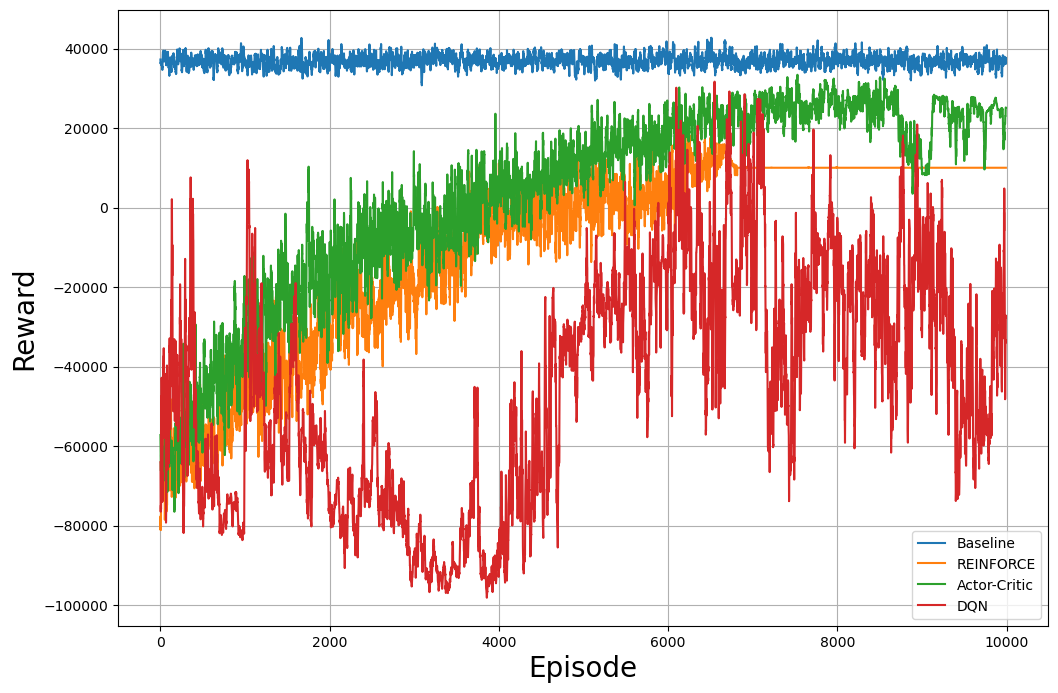

In [ ]:
window_size = 10
weights = np.ones(window_size) / window_size
baseline_smoothed = np.convolve(config_avg_baseline, weights, mode='valid')
REINFORCE_smoothed = np.convolve(config_avg_REINFORCE, weights, mode='valid')
AC_smoothed = np.convolve(config_avg_AC, weights, mode='valid')
DQN_smoothed = np.convolve(config_avg_DQN, weights, mode='valid')
plt.figure(figsize=(12,8))
plt.plot(baseline_smoothed, label='Baseline')
plt.plot(REINFORCE_smoothed, label='REINFORCE')
plt.plot(AC_smoothed, label='Actor-Critic')
plt.plot(DQN_smoothed, label='DQN')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.legend(loc='lower right')
plt.grid()